In [2]:
# data from https://www.10xgenomics.com/datasets/xenium-human-brain-preview-data-1-standard
# Applications of Sptial Omics Intersession 2026
# Suwen's Project
# Assisted by ChatGPT

In [4]:
!pip install scanpy squidpy anndata numpy harmonypy matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.3/183.3 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━

In [25]:
!pip install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 69.5 MB/s eta 0:00:00


Import Statements

In [63]:
import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np
import harmonypy as hm
import matplotlib.pyplot as plt

Load Data

In [55]:
# load data
healthy = sc.read_10x_mtx(
    "healthy",
    var_names="gene_symbols",
    cache=True
)

alz = sc.read_10x_mtx(
    "alzheimers",
    var_names="gene_symbols",
    cache=True
)

healthy.obs["condition"] = "Healthy"
alz.obs["condition"] = "Alzheimers"

print("Data loaded.")

Data loaded.


Filter Data

In [62]:
# quality control
def filter(adata):
    # mark mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")

    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt"],
        percent_top=None,
        inplace=True
    )

    print("Number of genes before filtering:", adata.n_vars)
    print("Number of cells before filtering:", adata.n_obs)

    # filter cells with < 20 genes total
    adata = adata[(adata.obs.n_genes_by_counts > 20)]

    # filter genes expressed in fewer than 3 spots
    sc.pp.filter_genes(adata, min_cells=3)

    print("Number of genes after filtering:", adata.n_vars)
    print("Number of cells after filtering:", adata.n_obs, "\n")
    return adata

print("Filtering healthy genes.")
healthy = filter(healthy)
print("Filtering alzheimers genes")
alz = filter(alz)

Filtering healthy genes.
Number of genes before filtering: 319
Number of cells before filtering: 24043
Number of genes after filtering: 319
Number of cells after filtering: 24043 

Filtering alzheimers genes
Number of genes before filtering: 354
Number of cells before filtering: 35903
Number of genes after filtering: 354
Number of cells after filtering: 35903 



/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


/tmp/ipython-input-496730632.py:9: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = healthy.concatenate(alz, batch_key="condition", batch_categories=["Healthy", "Alzheimers"])


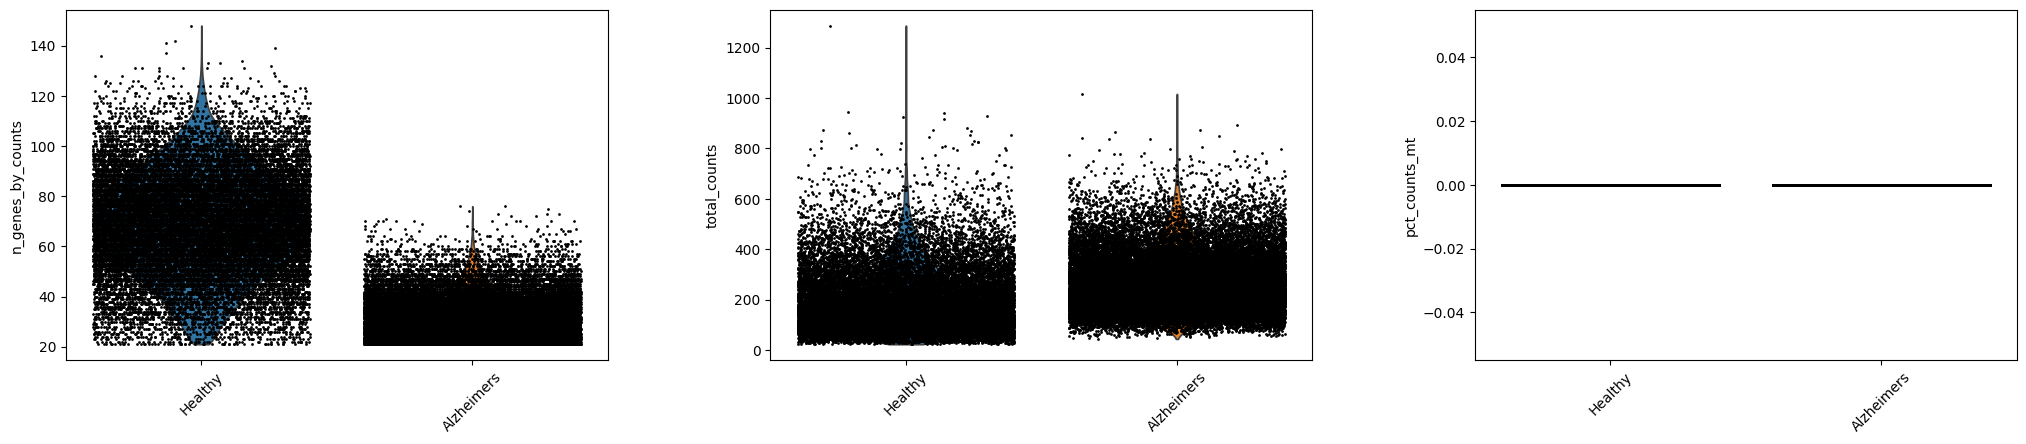

In [59]:
# visualization
# Make sure QC metrics exist
for a in [healthy, alz]:
    if "pct_counts_mt" not in a.obs:
        a.var["mt"] = a.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(a, qc_vars=["mt"], inplace=True)

# Combine datasets if you want side-by-side
adata = healthy.concatenate(alz, batch_key="condition", batch_categories=["Healthy", "Alzheimers"])

# Violin plot for QC metrics
qc_metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt"]

sc.pl.violin(
    adata,
    keys=qc_metrics,
    groupby="condition",   # shows healthy vs AD side by side
    rotation=45,
    jitter=0.4,
    multi_panel=True,      # separate panel per metric
    size=2                 # point size
)

Concatenate genes + Normalize

In [64]:
# concantenate genes
adata = ad.concat(
    [healthy, alz],
    join="outer",
    label="sample",
    keys=["Healthy", "Alzheimers"],
    fill_value=0
)
adata.obs_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata

print("normalized and log-transform data")

sc.pp.highly_variable_genes(
    adata,
    batch_key="sample",
    n_top_genes=3000
)

adata = adata[:, adata.var.highly_variable]

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


normalized and log-transform data


Harmonize Data

In [84]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50)

sc.pp.neighbors(
    adata,
    use_rep="X_pca"
)
sc.tl.umap(adata)

sc.tl.leiden(adata, key_added="leiden_pre")

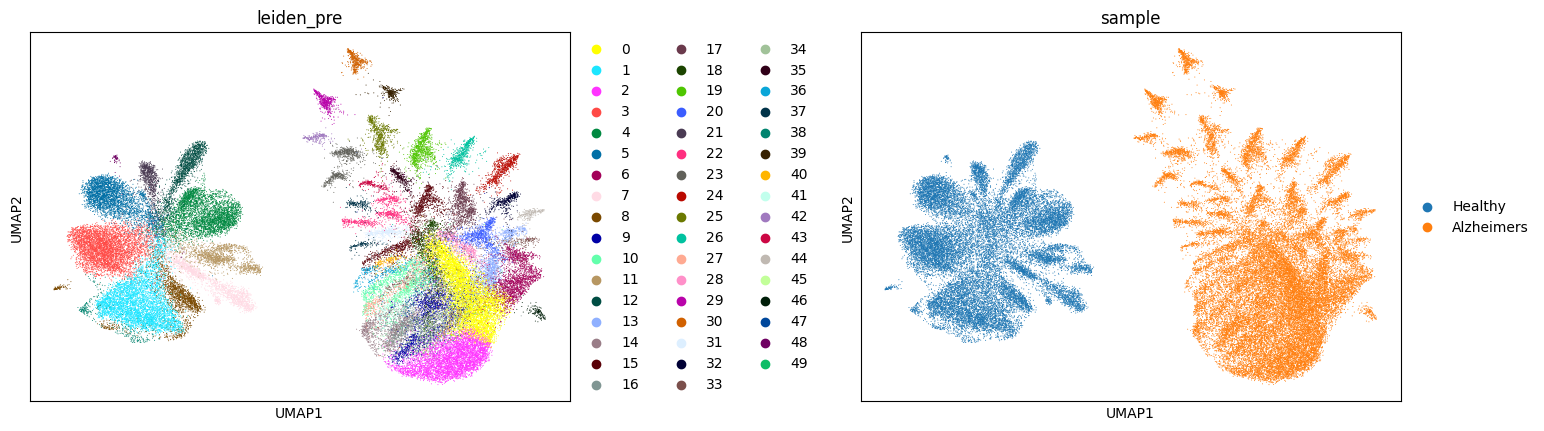

In [85]:
sc.pl.umap(
    adata,
    color=["leiden_pre", "sample"],
    wspace=0.4
)

In [101]:
# harmonization
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=20)

ho = hm.run_harmony(
    adata.obsm["X_pca"],
    adata.obs,
    vars_use=["sample"],
    theta=11, # Increased theta for more aggressive harmonization
    max_iter_harmony=50
)

adata.obsm["X_pca_harmony"] = ho.Z_corr

print("harmonized")

sc.pp.neighbors(
    adata,
    use_rep="X_pca_harmony"
)

2026-01-14 15:01:04,991 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
INFO:harmonypy:Running Harmony (PyTorch on cpu)
2026-01-14 15:01:04,996 - harmonypy - INFO -   Parameters:
INFO:harmonypy:  Parameters:
2026-01-14 15:01:05,002 - harmonypy - INFO -     max_iter_harmony: 50
INFO:harmonypy:    max_iter_harmony: 50
2026-01-14 15:01:05,004 - harmonypy - INFO -     max_iter_kmeans: 20
INFO:harmonypy:    max_iter_kmeans: 20
2026-01-14 15:01:05,009 - harmonypy - INFO -     epsilon_cluster: 1e-05
INFO:harmonypy:    epsilon_cluster: 1e-05
2026-01-14 15:01:05,013 - harmonypy - INFO -     epsilon_harmony: 0.0001
INFO:harmonypy:    epsilon_harmony: 0.0001
2026-01-14 15:01:05,016 - harmonypy - INFO -     nclust: 100
INFO:harmonypy:    nclust: 100
2026-01-14 15:01:05,020 - harmonypy - INFO -     block_size: 0.05
INFO:harmonypy:    block_size: 0.05
2026-01-14 15:01:05,026 - harmonypy - INFO -     lamb: [1. 1.]
INFO:harmonypy:    lamb: [1. 1.]
2026-01-14 15:01:05,032 - harmonypy - INFO -    

harmonized


In [102]:
sc.pp.neighbors(
    adata,
    use_rep="X_pca_harmony"
)
sc.tl.umap(adata)

sc.tl.leiden(adata, key_added="leiden_post")

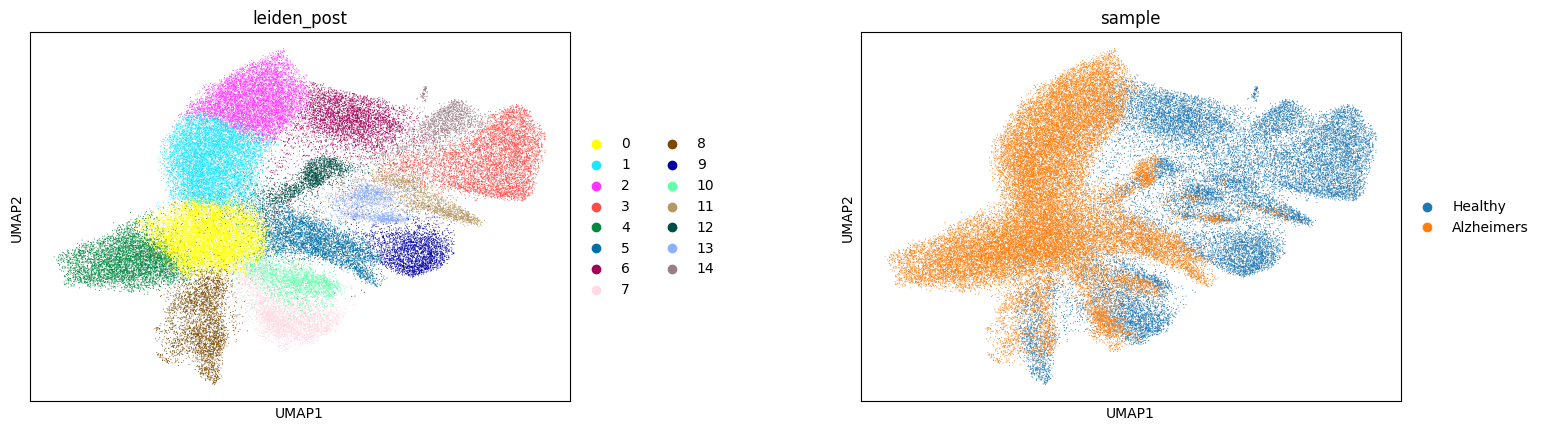

In [103]:
sc.pl.umap(
    adata,
    color=["leiden_post", "sample"],
    wspace=0.4
)

Annotate Cell Types

In [105]:
sc.tl.rank_genes_groups(adata, 'leiden_post', method='wilcoxon')
print("Identified marker genes for each 'leiden_post' cluster.")

Identified marker genes for each 'leiden_post' cluster.


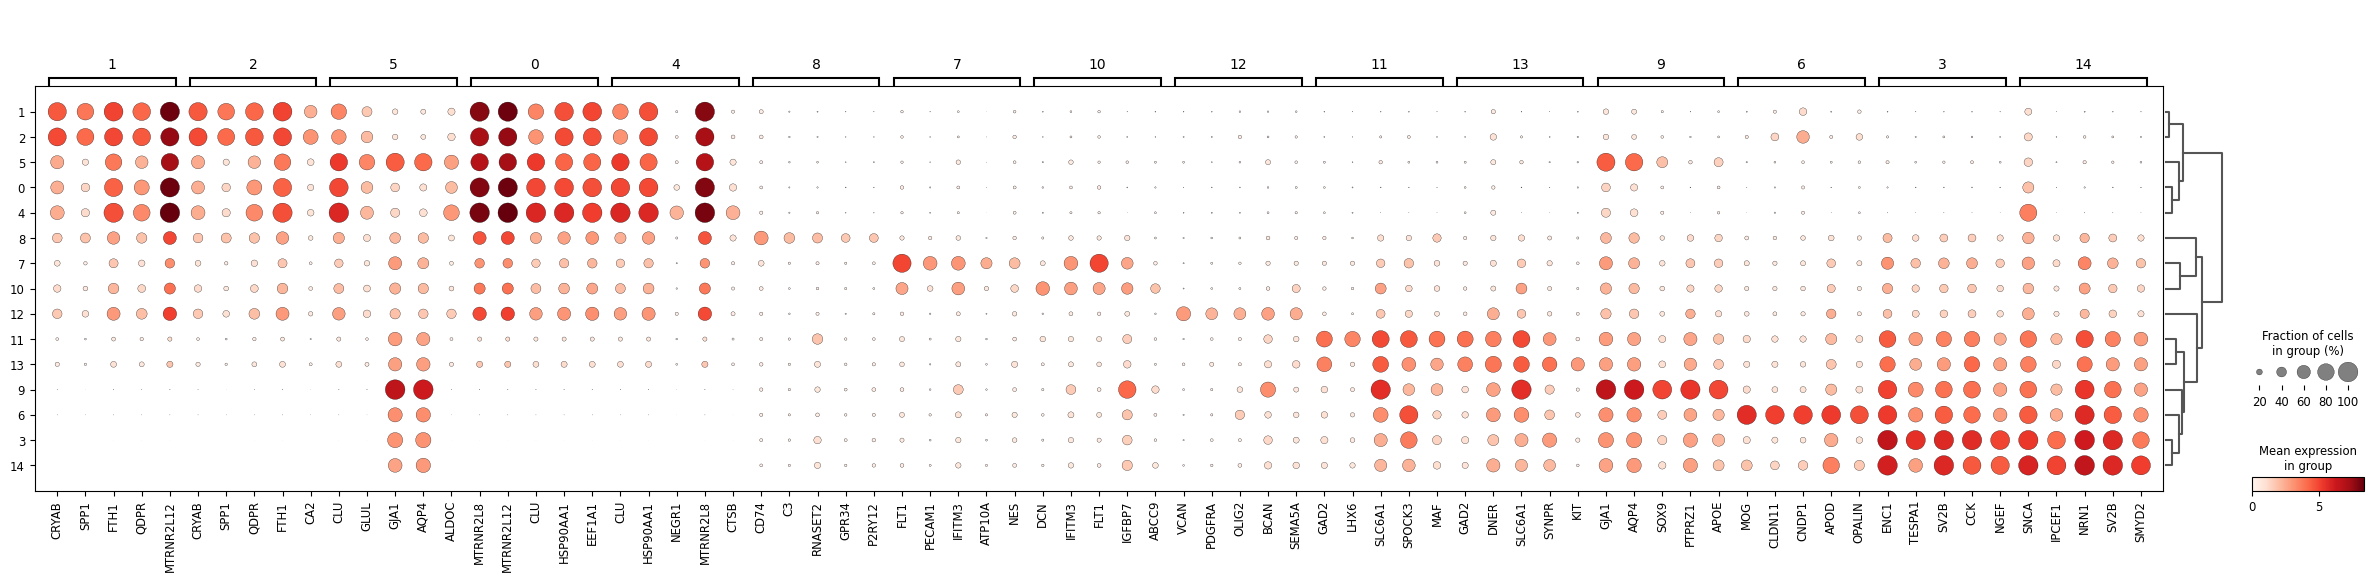

In [106]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby='leiden_post', dendrogram=True)

Cell Labels
1: